# Hierarchical model with spatial constraint

In [2]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import ipdb

In [7]:
nodes = pd.read_csv('Proj_Data/node.csv', index_col=0)
nodes['index abs'] = range(len(nodes))
edges = pd.read_csv('Proj_Data/edges_with_qkv.csv', index_col=0)

In [8]:
nodes

,index,ID,q,k,v,Long,Lat,index abs
0,0,715898,410.684028,0.090358,62.457812,-118.021787,33.880183,0
1,3,715929,405.503472,0.154721,54.573437,-118.123095,33.971707,1
2,5,715933,383.663194,0.131772,56.324479,-118.130679,33.981839,2
3,6,715938,393.451389,0.137075,54.980208,-118.150997,34.002541,3
4,7,715944,381.265625,0.151283,56.689583,-118.166091,34.013676,4
...,...,...,...,...,...,...,...,...
1316,1863,776457,308.024306,0.048418,68.017014,-118.712596,34.140004,1299
1317,1864,776465,252.569444,0.050435,66.585069,-118.865433,34.176675,1300
1318,1865,776480,318.086806,0.165058,53.344792,-118.231606,34.053569,1301
1319,1866,776487,314.135417,0.066274,64.290278,-117.997784,34.079858,1302


In [14]:
connectivity_mat = np.zeros([nodes.shape[0], nodes.shape[0]])
for i in range(len(edges)):
    from_ = edges.loc[i, 'node1']
    from_ = nodes.loc[from_, 'index abs']
    to_ = edges.loc[i, 'node2']
    to_ = nodes.loc[to_, 'index abs']
    
    connectivity_mat[from_, to_] = 1
    connectivity_mat[to_, from_] = 1

In [38]:
# Set seed for reproducibility
np.random.seed(0)
# Iniciate the algorithm, 'ward' means minimize variance in each cluster
model = AgglomerativeClustering(linkage='ward', connectivity=connectivity_mat, n_clusters=4)
# Run clustering
model.fit(nodes[['Long', 'Lat', 'q']])
# Assign labels to main data table
nodes['cls'] = model.labels_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:247: UserWarning: the number of connected components of the connectivity matrix is 5 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


In [39]:
data_new = pd.read_csv('./Proj_Data/2019-10-21_with_cord.csv', index_col=0)
data_new = data_new.loc[data_new['Lane type']=='ML']

data_new['cls'] = ''
for i in nodes.index:
#     ipdb.set_trace()
    ID = nodes.loc[i, 'ID']
    cls = nodes.loc[i, 'cls']
    data_new.loc[data_new['ID']==int(ID), 'cls'] = cls
data_new['q0'] = data_new['q'] * 12
data_new['k0'] = data_new['q0'] / data_new['Avg v']

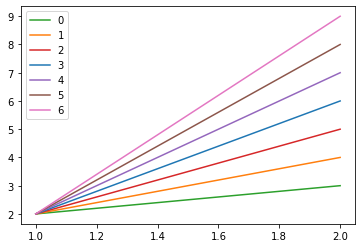

In [40]:
color_set = ['#2ca02c', '#ff7f0e', '#d62728', '#1f77b4', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(3,10):
    plt.plot([1,2], [2,i], color=color_set[i-3], label=str(i-3))
plt.legend()

There are 4 classes


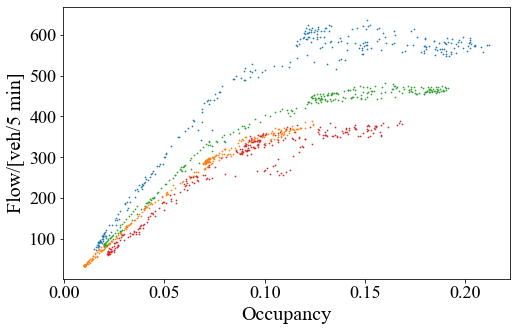

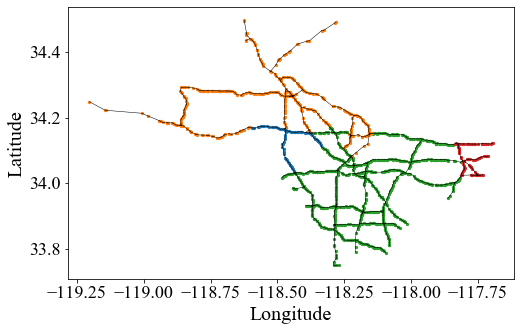

In [43]:
c = 0
c_set = []

plt.rcParams['font.family'] = 'Times New Roman'
fig_mfd = plt.figure(figsize=[8,5])
ax_mfd = fig_mfd.add_subplot(111)
fig_net = plt.figure(figsize=[8,5])
ax_net = fig_net.add_subplot(111)

for i in edges.index:
    node1 = edges.loc[i, 'node1']
    node2 = edges.loc[i, 'node2']
    ax_net.plot([nodes.loc[node1, 'Long'], nodes.loc[node2, 'Long']], [nodes.loc[node1, 'Lat'], nodes.loc[node2, 'Lat']], 'black', lw=0.5)

ft = 20
font = {'family': 'Times New Roman',
         'weight': 'normal',
        'size': ft,
        }

for i in [0,1,2,3]:
    data_cls = data_new.loc[data_new['cls']==i].sort_values(by=['ID', 'Time'])
    q_cls = data_cls['q'].values
    if q_cls.reshape(-1, 288).shape[0] <= 1:
        continue
    q_cls_avg = q_cls.reshape(-1, 288).mean(axis=0)
    k_cls = data_cls['Avg k'].values
    k_cls_avg = k_cls.reshape(-1, 288).mean(axis=0)
    ax_mfd.scatter(k_cls_avg, q_cls_avg, s=.5, c=color_set[c])
    ax_mfd.set_xlabel('Occupancy', fontdict=font)
    ax_mfd.set_ylabel('Flow/[veh/5 min]', fontdict=font)
    ax_mfd.tick_params(axis='both', which='major', labelsize=ft*0.9)
    
    lng = nodes.loc[nodes['cls']==i, 'Long']
    lat = nodes.loc[nodes['cls']==i, 'Lat']
    ax_net.scatter(lng, lat, s=5, c=color_set[c])
    ax_net.set_xlabel('Longitude', fontdict=font)
    ax_net.set_ylabel('Latitude', fontdict=font)
    ax_net.tick_params(axis='both', which='major', labelsize=ft*0.9)
    c+=1
    c_set.append(i)

    
print('There are %i classes'%c)
fig_mfd.savefig('./img/HS_fig_mfd.png', dpi=500)
fig_net.savefig('./img/HS_fig_net.png', dpi=500)